Домашнее задание по NLP # 2 [100 баллов]
Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    тест на определение ближайших слов
    тест на аналогии (мужчина – король : женщина – королева)
    тест на определение лишнего слова.

In [1]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import re
import gensim
import logging
import nltk.data
import urllib.request
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FED\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:52, 1785.27it/s]


In [4]:
positive = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 5][:10000]
negative = pd.DataFrame(responses).dropna()[pd.DataFrame(responses).dropna()['rating_grade'] == 1][:10000]

In [5]:
data = pd.concat([positive, negative], axis=0)

In [6]:
from sklearn.utils import shuffle
data = shuffle(data)

In [7]:
# data.info()

In [8]:
# data.describe()

In [9]:
data.rating_grade.value_counts()

1.0    10000
5.0    10000
Name: rating_grade, dtype: int64

In [10]:
# urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")

In [11]:
model_path = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'
model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [12]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')

In [13]:
 from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()
def lemmatize(text):
    try:
        return " ".join(pymorphy2_analyzer.parse(word)[0].normal_form for word in text.split())
    except:
        return " "

In [14]:
def review_to_wordlist(review, remove_stopwords=False ):
    # убираем ссылки вне тегов
#     review = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
#     review_text = BeautifulSoup(review, "lxml").get_text()
#     review_text = re.sub("[^a-zA-Z]"," ", review_text)
    review_text = re.sub("[^а-яА-Я]"," ", review)
    review_text = lemmatize(review_text)
    words = review_text.lower().split()
#     words = review.lower().split()
    if remove_stopwords:
        stops = stopwords.words("russian")
        words = [w for w in words if not w in stops]
    return(words)

def review_to_sentences(review, tokenizer, remove_stopwords=True):
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [15]:
# %%time
# sentences = []  

# print("Parsing sentences from training set...")
# for review in data.text:
#     sentences += review_to_sentences(review, tokenizer)

In [16]:
sentences = []
with open('clean_text.txt', 'r') as f:
    text = f.read()
    for sent in text.split('\n'):
        sentences.append(sent.split(' '))

In [18]:
# sentences

In [19]:
print(len(sentences))
print(sentences[0])

335550
['подавать', 'претензия', 'черёмушки', 'предмет', 'некорректно', 'начислить', 'процент', 'телефонный', 'карта', 'июнь']


In [20]:
# # это понадобится нам позже

# with open('clean_text.txt', 'w') as f:
#     for s in sentences:
#         f.write(' '.join(s))
#         f.write('\n')

In [21]:
print("Training model...")

%time model_ru = word2vec.Word2Vec(sentences, workers=4, size=300, min_count=10, window=10, sample=1e-3)

Training model...
Wall time: 18 s


In [23]:
print(len(model_ru.wv.vocab))

10124


In [24]:
print(model_ru.wv.most_similar(positive=["отделение", "банк"], negative=["сотрудник"], topn=1))
print(model_ru.wv.most_similar(positive=["кредит", "просрочить"], negative=["банк"], topn=1))
print(model_ru.wv.most_similar("ипотека", topn=3))
print(model_ru.wv.most_similar("банк", topn=3))
print(model_ru.wv.most_similar("кредит", topn=10))

print(model_ru.wv.doesnt_match("банк кредит вклад задолженность".split()))

[('офис', 0.4782058298587799)]
[('просрочка', 0.6224362850189209)]
[('автокредит', 0.8207608461380005), ('кредит', 0.7059550285339355), ('ипотечный', 0.6474920511245728)]
[('директ', 0.4190494418144226), ('мкб', 0.40979355573654175), ('псб', 0.3973877429962158)]
[('автокредит', 0.7494534254074097), ('ипотека', 0.7059549689292908), ('рассрочка', 0.6633217930793762), ('заём', 0.5455808043479919), ('досрочно', 0.5265196561813354), ('долг', 0.5142802000045776), ('кредитование', 0.5095962285995483), ('ежемесячный', 0.5007078647613525), ('потреба', 0.4915771484375), ('рефинансирование', 0.4862525463104248)]
вклад


C:\Users\FED\anaconda3\lib\site-packages\gensim\models\keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


Постройте несколько визуализаций:

TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов

задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [25]:
from nltk import FreqDist
from tqdm import tqdm_notebook as tqdm
from sklearn.manifold import TSNE

In [26]:
top_words = []


fd = FreqDist()
for s in tqdm(sentences):
    fd.update(s)

for w in fd.most_common(500):
    top_words.append(w[0])
    
# print(top_words[:500:])
top_words_vec = model_ru[top_words]

<ipython-input-26-ba95099ac3ed>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for s in tqdm(sentences):


<ipython-input-26-ba95099ac3ed>:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  top_words_vec = model_ru[top_words]


In [27]:
%%time
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

Wall time: 3.19 s


In [28]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (ru model, top500 words)")

source = ColumnDataSource(data=dict(x1 = top_words_tsne[:,0],
                                    x2 = top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

In [29]:
# Примеры наиболее осмысленных кластеров

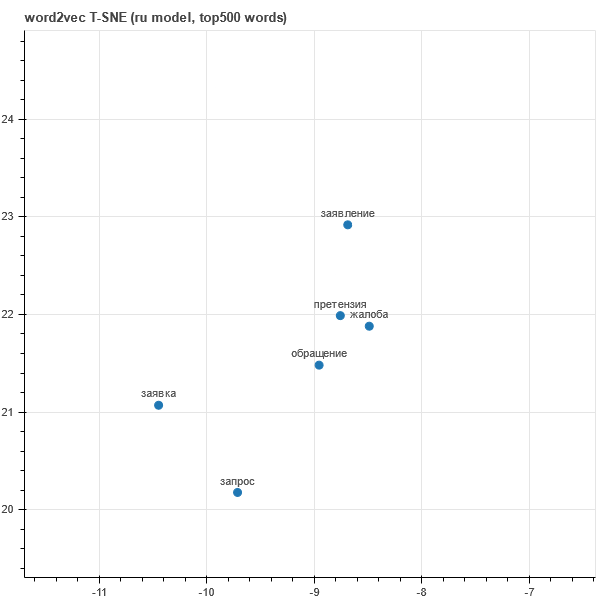

In [30]:
from IPython.display import Image
Image(filename='bokeh_plot.png', width=400, height=400)

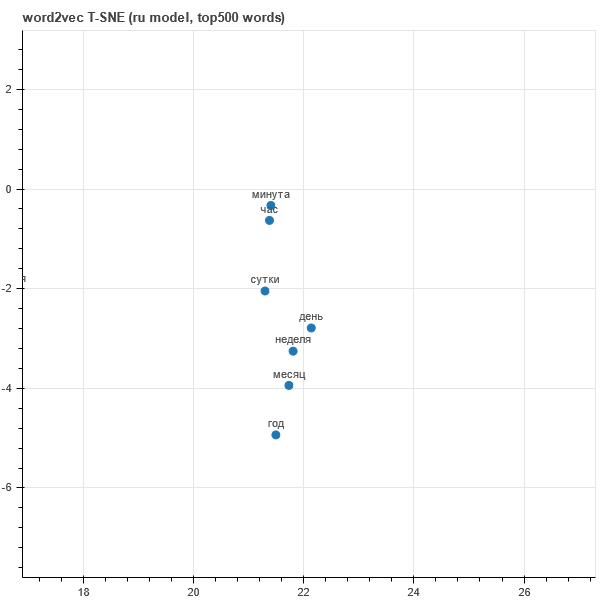

In [31]:
Image(filename='bokeh_plot(1).png', width=400, height=400) 

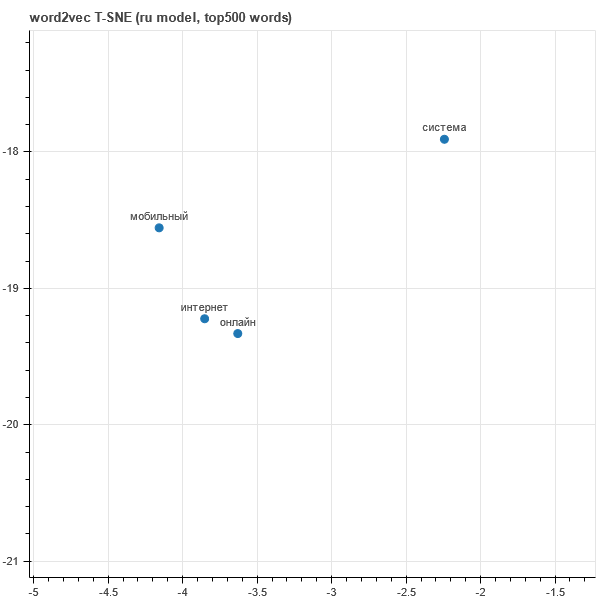

In [32]:
Image(filename='bokeh_plot(2).png', width=400, height=400) 

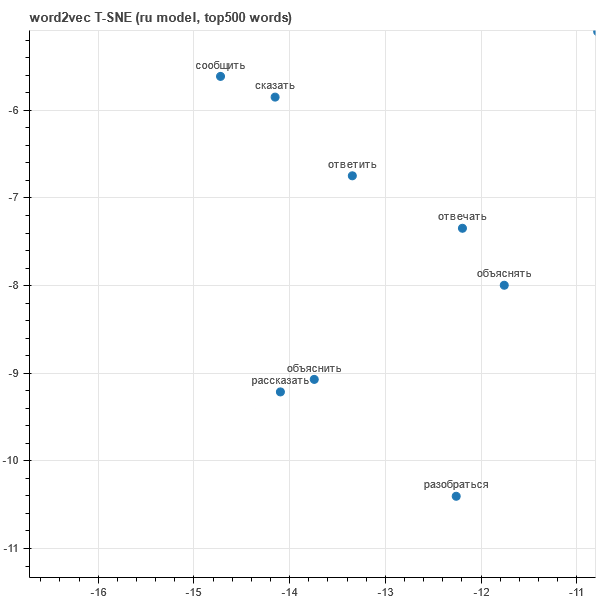

In [33]:
Image(filename='bokeh_plot(3).png', width=400, height=400) 

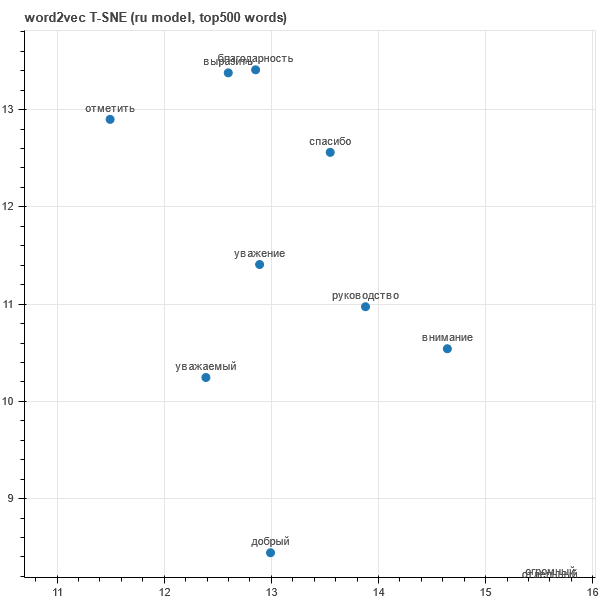

In [34]:
Image(filename='bokeh_plot(4).png', width=400, height=400) 

задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах.

Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [35]:
x = model_ru.wv['отлично'] - model_ru.wv['плохо']
# x

In [36]:
y = model_ru.wv['быстро'] - model_ru.wv['медленно']
# y

In [37]:
bank_list = ['сбербанк', 'втб', 'альфабанк', 'возрождение', 'совкомбанк', 'мкб', 'уралсиб', 'россельхозбанк', 'тинькофф']

In [38]:
banks = {}
banks_x = []
banks_y = []
for bank in bank_list:
    if bank in model_ru.wv.vocab:
        banks[bank]=[model_ru.wv[bank] * x, model_ru.wv[bank] * y]
        banks_x.append(model_ru.wv[bank] * x)
        banks_y.append(model_ru.wv[bank] * y)

In [39]:
%%time
tsne = TSNE(n_components=1, random_state=0)
banks_tsne_x = tsne.fit_transform(banks_x)
banks_tsne_y = tsne.fit_transform(banks_y)

Wall time: 508 ms


In [40]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="плохо-хорошо, медленно-быстро")

source = ColumnDataSource(data=dict(x1 = banks_tsne_x,
                                    x2 = banks_tsne_y,
                                    names=list(banks.keys())))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

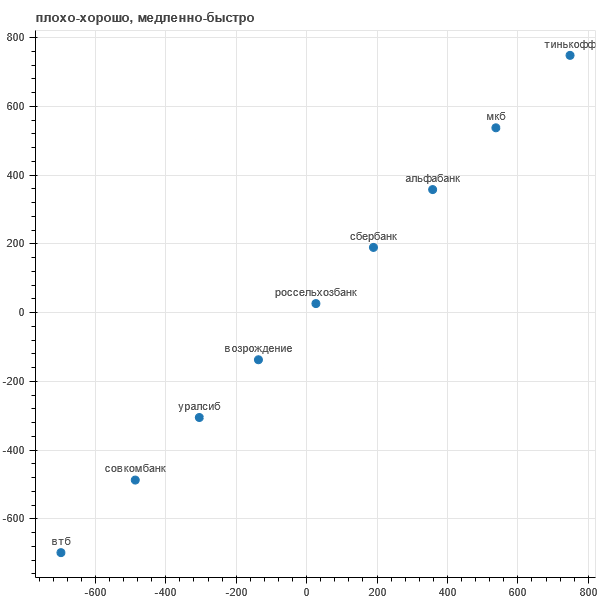

In [42]:
Image(filename='bokeh_plot (2).png') 